In [1]:
import pandas as pd
import numpy as np
from six.moves import cPickle
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('..')

In [2]:
from src import *
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置主题色和ggplot模版
PingFang = FontProperties(fname='../assets/PingFang.ttc')
plt.style.use('ggplot')
plt_color = ["#ACA7CB", "#474554"]

In [3]:
yelp = pd.read_csv('../data/Yelp_final.csv', encoding='utf-8')

yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112117 entries, 0 to 1112116
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1112117 non-null  object
 1   review_id    1112117 non-null  object
 2   business_id  1112117 non-null  object
 3   stars        1112117 non-null  int64 
 4   type         1112117 non-null  object
 5   city         1112117 non-null  object
 6   categories   1112117 non-null  object
dtypes: int64(1), object(6)
memory usage: 59.4+ MB


# 1 过滤出位于Scottsdale的餐厅评论

In [4]:
# 
restaurant_reviews = yelp[(yelp.city == 'Scottsdale') &
                          (yelp.categories.str.contains('.Restaurant.', case=False))]

print("Scottsdale餐厅评论的行列数:", restaurant_reviews.shape)

Scottsdale餐厅评论的行列数: (63075, 7)


获取每位用户至少有10条评论的Scottsdale餐厅数据

In [5]:
reviews_min_10 = get_clean_df(restaurant_reviews,
                              min_user_review=10, cols=['user_id', 'business_id', 'stars'])

print("至少有10条评论的Scottsdale餐厅评论数:", reviews_min_10.shape[0])

至少有10条评论的Scottsdale餐厅评论数: 21425


计算Scottsdale餐厅的唯一餐厅数和唯一用户数

In [6]:
print("Scottsdale唯一餐厅数 =", len(reviews_min_10.business_id.unique()))
print("Scottsdale唯一用户数 =", len(reviews_min_10.user_id.unique()))

Scottsdale唯一餐厅数 = 910
Scottsdale唯一用户数 = 949


计算Scottsdale餐厅的稀疏矩阵

In [7]:
ratings_matrix = get_sparse_matrix(reviews_min_10)
print("Scottsdale餐厅评分矩阵的形状 =", ratings_matrix.shape)

Scottsdale餐厅评分矩阵的形状 = (949, 910)


计算Scottsdale餐厅评分矩阵的稀疏度

In [8]:

sparsity_scottsdale = 1 - ratings_matrix.nnz / \
    (ratings_matrix.shape[0] * ratings_matrix.shape[1])
    
print("Scottsdale餐厅评分矩阵的稀疏度 =", sparsity_scottsdale)

Scottsdale餐厅评分矩阵的稀疏度 = 0.9751907733994141


In [9]:
# 处理Scottsdale餐厅评分矩阵
train_matrix, val_matrix, test_matrix = train_val_test_split(
    ratings_matrix)
print("Scottsdale 训练集形状:", train_matrix.shape)
print("Scottsdale 验证集形状:", val_matrix.shape)
print("Scottsdale 测试集形状:", test_matrix.shape)

c:\Users\Earth\anaconda3\envs\DataWarehouse-ENV\lib\site-packages\scipy\sparse\_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Scottsdale 训练集形状: (949, 910)
Scottsdale 验证集形状: (949, 910)
Scottsdale 测试集形状: (949, 910)


# 2 模型构建
## 2.1 奇异值分解SVD

In [10]:
# 计算斯科茨代尔训练矩阵的奇异值分解
U_Restaurant, S_Restaurant, Vt_Restaurant = np.linalg.svd(
    train_matrix.todense())

# 打印最小和最大的奇异值
print("最小奇异值 = ", min(S_Restaurant))
print("最大的奇异值 = ", max(S_Restaurant))

# 将奇异值对角化
S_Diagonal = np.diag(S_Restaurant)

最小奇异值 =  1.3367626518753838e-14
最大的奇异值 =  170.019692163856


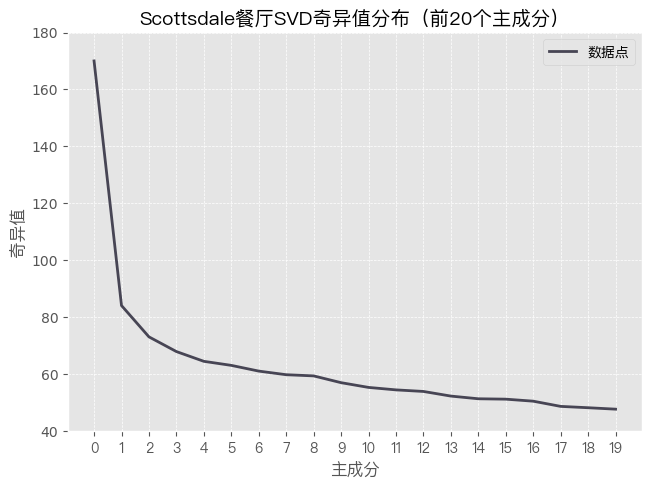

In [11]:
# 绘制前20个奇异值的Elbow图
plt.plot(S_Restaurant[:20], '-', linewidth=2,
         color=plt_color[1], label='数据点')

plt.xticks(np.arange(0, len(S_Restaurant[:20]), 1), fontproperties=PingFang)
plt.xlabel('主成分', fontproperties=PingFang, fontsize=12)
plt.ylim(40, 180)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(prop=PingFang)


plt.tight_layout()
plt.savefig('../images/Scottsdale/01_SVD奇异值分布_前20个主成分.png', dpi=600)
plt.ylabel('奇异值', fontproperties=PingFang, fontsize=12)
plt.title('Scottsdale餐厅SVD奇异值分布（前20个主成分）',
          fontproperties=PingFang, fontsize=14)
plt.show()

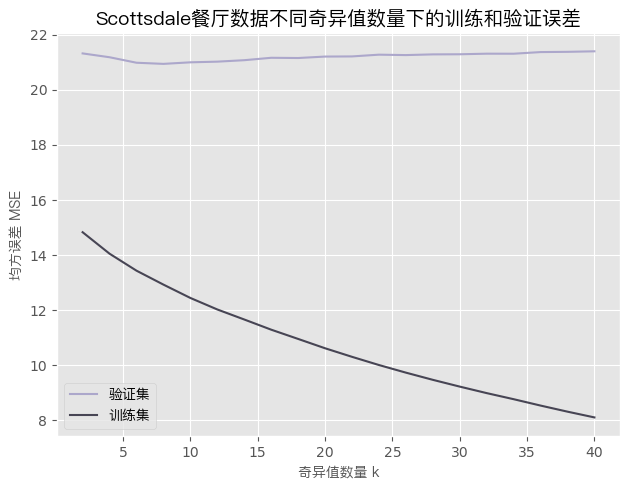

In [12]:
# 设置奇异值数量的范围
num_singular_values_range = np.linspace(2, 40, 20, dtype=int)
errors_svd_val_sct = {}
errors_svd_train_sct = {}

# 计算Scottsdale餐厅数据在不同奇异值数量下的训练误差和验证误差
for num_singular_values in num_singular_values_range:
    errors_svd_val_sct[num_singular_values] = compute_approximation_error(
        num_singular_values, val_matrix.todense(), U_Restaurant, S_Diagonal, Vt_Restaurant)
    errors_svd_train_sct[num_singular_values] = compute_approximation_error(
        num_singular_values, train_matrix.todense(), U_Restaurant, S_Diagonal, Vt_Restaurant)

# 绘制训练误差和验证误差图
plt.plot(errors_svd_val_sct.keys(), errors_svd_val_sct.values(),
         label='验证集', color=plt_color[0])
plt.plot(errors_svd_train_sct.keys(), errors_svd_train_sct.values(),
         label='训练集', color=plt_color[1])

plt.xlabel('奇异值数量 k', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)
plt.legend(prop=PingFang)

plt.tight_layout()
plt.savefig('../images/Scottsdale/02_不同奇异值数量下验证集误差.png', dpi=600)
plt.title('Scottsdale餐厅数据不同奇异值数量下的训练和验证误差',
          fontproperties=PingFang, fontsize=14)

plt.show()

验证错误在每个阶段后都会增加

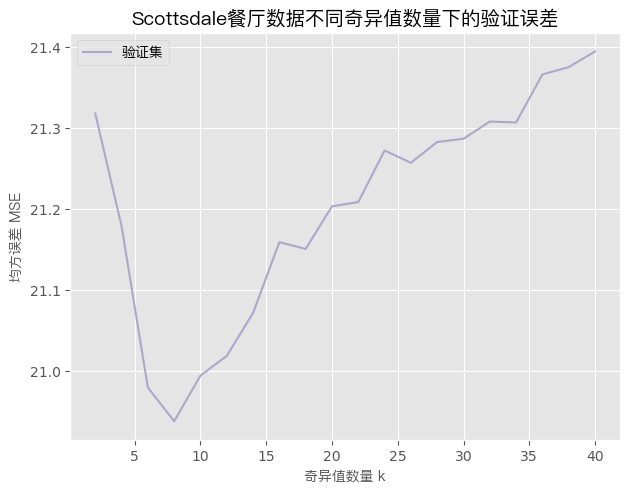

In [13]:
# 单独绘制验证误差图
plt.plot(errors_svd_val_sct.keys(), errors_svd_val_sct.values(),
         label='验证集', color=plt_color[0])

plt.xlabel('奇异值数量 k', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)

plt.legend(prop=PingFang)

plt.tight_layout()
plt.savefig('../images/Scottsdale/03_不同奇异值数量下验证集误差.png', dpi=600)
plt.title('Scottsdale餐厅数据不同奇异值数量下的验证误差', fontproperties=PingFang, fontsize=14)
plt.show()

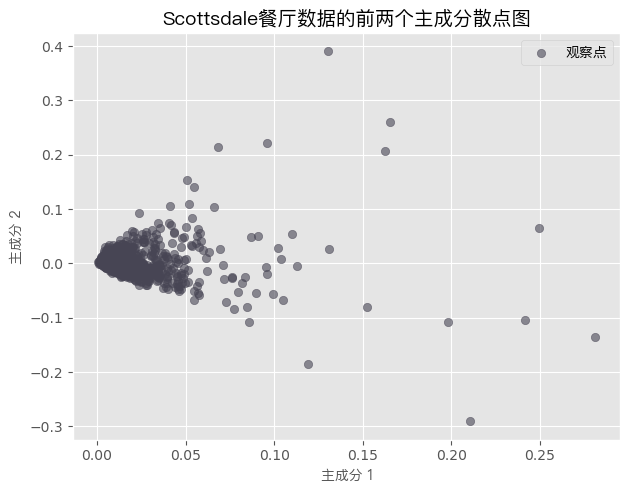

In [14]:
# 使用SVD结果中的前两个主成分绘制散点图
plt.scatter(np.ravel(U_Restaurant[:, 0]), np.ravel(
    U_Restaurant[:, 1]), label='观察点', color=plt_color[1], alpha=0.6)

plt.xlabel('主成分 1', fontproperties=PingFang)
plt.ylabel('主成分 2', fontproperties=PingFang)

plt.legend(prop=PingFang)
plt.tight_layout()
plt.savefig('../images/Scottsdale/04_前两个主成分散点图.png', dpi=600)

# 设置标题
plt.title('Scottsdale餐厅数据的前两个主成分散点图', fontproperties=PingFang, fontsize=14)
# 显示图像
plt.show()

In [15]:
# 计算在使用前16个奇异值进行近似重构时，Scottsdale餐厅数据在验证集上的最佳均方误差（MSE）
best_val_mse_svd = compute_approximation_error(
    16, val_matrix.todense(), U_Restaurant, S_Diagonal, Vt_Restaurant)

print('Scottsdale餐厅使用SVD的最佳验证集均方误差 (MSE)= ', best_val_mse_svd)

Scottsdale餐厅使用SVD的最佳验证集均方误差 (MSE)=  21.1593733349998


In [16]:
# 训练集非零元素的索引
train_nonzero_indices = train_matrix.nonzero()

# 验证集非零元素的索引
val_nonzero_indices = val_matrix.nonzero()

# 测试集非零元素的索引
test_nonzero_indices = test_matrix.nonzero()

In [17]:
# 使用前15个奇异值进行SVD重构，计算重构后的矩阵
reconstructed_matrix_svd = np.dot(U_Restaurant[:, :15], np.dot(
    S_Diagonal[:15, :15], Vt_Restaurant[:15, :]))

# 获取训练集、验证集和测试集在重构矩阵中的预测值
train_predictions_svd = np.ravel(
    reconstructed_matrix_svd[train_nonzero_indices])
val_predictions_svd = np.ravel(
    reconstructed_matrix_svd[val_nonzero_indices])
test_predictions_svd = np.ravel(
    reconstructed_matrix_svd[test_nonzero_indices])

## 2.2 带偏差校正的SVD
`user_bias_ur_sct`：每个用户的评分偏差。

`res_bias_ur_sct`：每个商家的评分偏差。

`train_ur_sct`：去除用户和商家偏差后的评分矩阵。

In [18]:
# 对Scottsdale餐厅评分矩阵计算全局用户和商家偏差
user_bias, item_bias, train_matrix_wo_bias = compute_global_user_item_bias(
    train_matrix)

In [19]:
# 对去除偏差后的训练矩阵进行SVD分解
U_wo_bias_ur, S_wo_bias_ur, Vt_wo_bias_ur = np.linalg.svd(
    train_matrix_wo_bias)
print("最小的奇异值 = ", min(S_wo_bias_ur))
print("最大的奇异值 = ", max(S_wo_bias_ur))
S_Diagonal_wo_bias_ur = np.diag(S_wo_bias_ur)

最小的奇异值 =  7.057263340916776e-13
最大的奇异值 =  7084.089331524575


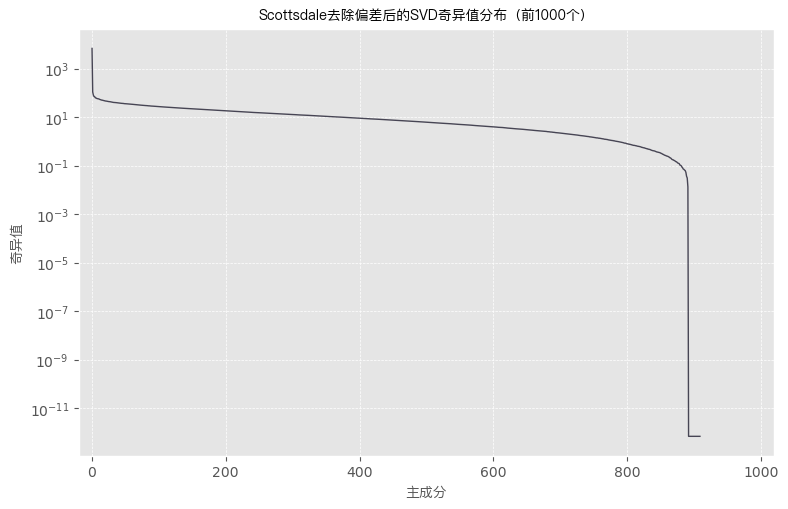

In [20]:
# 绘制前1000个奇异值的Elbow图
fig = plt.figure(figsize=(8, 5))
plt.semilogy(S_wo_bias_ur[:1000], '-', linewidth=1, color=plt_color[1])
plt.xlim(-20, 1020)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('主成分', fontproperties=PingFang)
plt.ylabel('奇异值', fontproperties=PingFang)
plt.tight_layout()
plt.savefig('../images/Scottsdale/05_去除偏差后的SVD_奇异值分布（前1000个）.png', dpi=600)
plt.title('Scottsdale去除偏差后的SVD奇异值分布（前1000个）', fontproperties=PingFang)
plt.show()

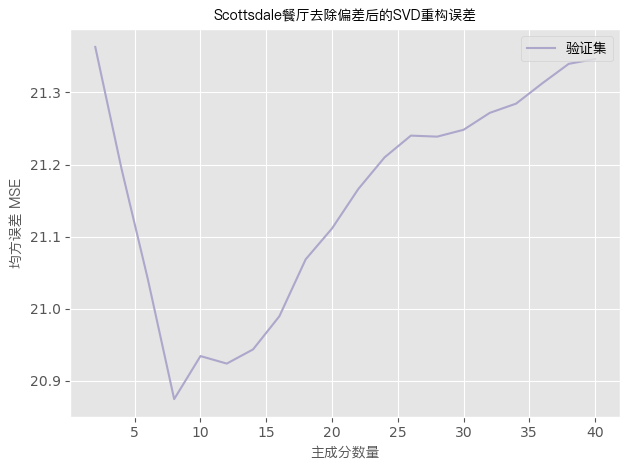

In [21]:
# 设置主成分数量的范围
num_components_wo_bias = np.linspace(2, 40, 20, dtype=int)
errors_svd_wo_bias_ur_sct = {}

# 去除偏差后的验证矩阵
sm_u_10_sct_res_val_wo_bias_ur = val_matrix.todense() - \
    user_bias - item_bias

# 计算不同主成分数量下的重构误差
for i in num_components_wo_bias:
    sm_u_10_sct_res_val_wo_bias_ur_rec = np.dot(U_wo_bias_ur[:, :i], np.dot(
        S_Diagonal_wo_bias_ur[:i, :i], Vt_wo_bias_ur[:i, :]))
    idx_wo_bias_ur_sct = np.where(val_matrix.todense() > 0)
    diff_wo_bias_ur_sct = sm_u_10_sct_res_val_wo_bias_ur[idx_wo_bias_ur_sct] - \
        sm_u_10_sct_res_val_wo_bias_ur_rec[idx_wo_bias_ur_sct]
    errors_svd_wo_bias_ur_sct[i] = np.linalg.norm(
        diff_wo_bias_ur_sct) ** 2 / diff_wo_bias_ur_sct.shape[1]

# 绘制不同主成分数量下的重构误差
plt.plot(errors_svd_wo_bias_ur_sct.keys(),
         errors_svd_wo_bias_ur_sct.values(), label='验证集',
         color=plt_color[0])
plt.xlabel('主成分数量', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)
plt.legend(prop=PingFang, loc='upper right')
plt.tight_layout()
plt.savefig('../images/Scottsdale/06_去除偏差后的SVD_验证集重构误差.png', dpi=600)
plt.title('Scottsdale餐厅去除偏差后的SVD重构误差', fontproperties=PingFang)
plt.tight_layout()
plt.show()

## 2.3 修正偏差的余弦相似度

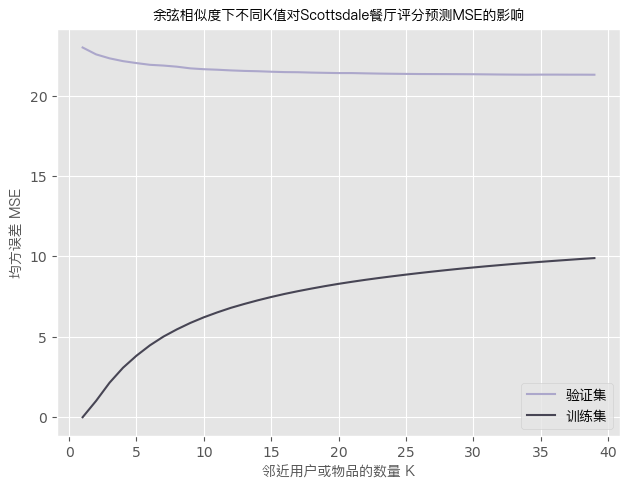

In [22]:
# 初始化存储MSE的字典
errors_cs_res_sct_val = {}
errors_cs_res_sct_train = {}

# 定义K值范围
k_cs = np.arange(1, 40)

# 计算Scottsdale餐厅数据的余弦相似性矩阵
simi_sct_res = compute_similarity_matrix(train_matrix, axis='res')
simi_sct_res = np.array(simi_sct_res)

# 对每个K值，使用余弦相似性模型预测评分，并计算MSE
for i in k_cs:
    preds_cs_res_sct = predict_top_k(
        np.array(train_matrix.todense()), simi_sct_res, kind='res', k=i)
    error_cs_val = calculate_mse(
        preds_cs_res_sct, np.array(val_matrix.todense()))
    error_cs_train = calculate_mse(
        preds_cs_res_sct, np.array(train_matrix.todense()))
    errors_cs_res_sct_val[i] = error_cs_val
    errors_cs_res_sct_train[i] = error_cs_train

# 绘制不同K值对应的MSE曲线
plt.plot(errors_cs_res_sct_val.keys(),
         errors_cs_res_sct_val.values(), label='验证集', color=plt_color[0])
plt.plot(errors_cs_res_sct_train.keys(),
         errors_cs_res_sct_train.values(), label='训练集', color=plt_color[1])

plt.xlabel('邻近用户或物品的数量 K', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)
plt.legend(prop=PingFang)
plt.tight_layout()
plt.savefig('../images/Scottsdale/09_余弦相似度模型_不同K值对评分预测MSE的影响.png', dpi=600)
plt.title('余弦相似度下不同K值对Scottsdale餐厅评分预测MSE的影响', fontproperties=PingFang)

plt.show()

In [23]:
# 使用K=40的余弦相似性模型对Scottsdale训练集数据进行预测
prediction_cos = predict_top_k(
    np.array(train_matrix.todense()), simi_sct_res, kind='res', k=40)

# 计算预测结果与验证集数据的均方误差（MSE）
Best_Val_MSE_Cosine_sct = calculate_mse(
    prediction_cos, np.array(val_matrix.todense()))

# 打印最佳验证集均方误差
print('Scottsdale餐厅余弦相似性模型在K=40时的最佳验证集MSE为 = ', Best_Val_MSE_Cosine_sct)

Scottsdale餐厅余弦相似性模型在K=40时的最佳验证集MSE为 =  21.300979222619475


In [24]:
train_prediction_cos = prediction_cos[train_nonzero_indices]
val_prediction_cos = prediction_cos[val_nonzero_indices]
test_prediction_cos = prediction_cos[test_nonzero_indices]

## 2.4 交替最小二乘法ALS

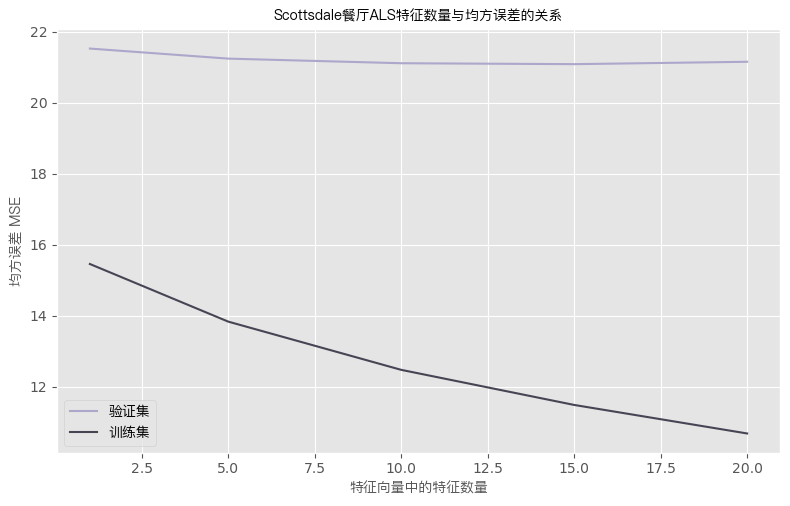

In [25]:
# 定义特征数量的范围
num_features = np.linspace(1, 20, 5, dtype=int)
test_error_als_sct = []  # 存储验证集误差
train_error_als_sct = []  # 存储训练集误差

# 遍历不同的特征数量
for i in num_features:
    # 使用ALS算法预测Scottsdale餐厅的评分
    preds_als = als(np.array(train_matrix.todense()),
                    num_features=i, iterations=5)

    # 计算验证集和训练集的均方误差
    test_err = calculate_mse(preds_als, np.array(
        val_matrix.todense()))
    train_err = calculate_mse(preds_als, np.array(
        train_matrix.todense()))

    # 将计算结果添加到列表中
    test_error_als_sct.append(test_err)
    train_error_als_sct.append(train_err)

# 创建图形对象并设置图形大小
fig = plt.figure(figsize=(8, 5))

# 绘制特征数量与均方误差的关系图
plt.plot(num_features, test_error_als_sct,
         label='验证集', color=plt_color[0])
plt.plot(num_features, train_error_als_sct,
         label='训练集', color=plt_color[1])


plt.xlabel('特征向量中的特征数量', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)

plt.legend(prop=PingFang)
plt.tight_layout()
plt.savefig('../images/Scottsdale/10_ALS_特征数量与均方误差的关系.png', dpi=600)
plt.title('Scottsdale餐厅ALS特征数量与均方误差的关系', fontproperties=PingFang)
plt.show()

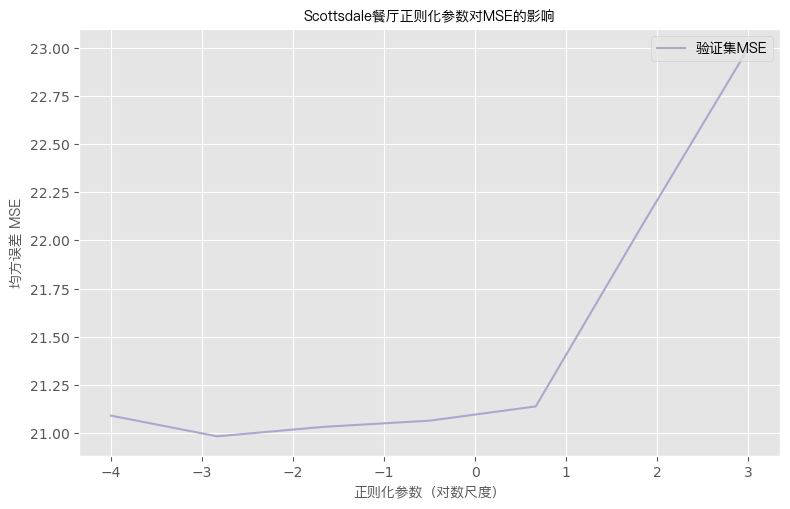

In [26]:
# 生成用户和物品的正则化参数，范围从10^-4到10^3，共7个点
user_reg = np.logspace(-4, 3, 7)
val_error_als = {}  # 初始化存储验证集误差的字典

# 创建图形对象并设置图形大小
fig = plt.figure(figsize=(8, 5))

# 遍历正则化参数
for i in user_reg:
    # 对每个正则化参数进行模型训练，并计算验证集上的均方误差
    preds_als = als(np.array(train_matrix.todense()), num_features=10, iterations=5,
                    user_regularization=i, item_regularization=i)
    val_err = calculate_mse(preds_als, np.array(
        val_matrix.todense()))
    val_error_als[i] = [val_err]  # 存储每个参数下的验证集MSE

# 绘制正则化参数（对数尺度）与MSE的关系图
plt.plot(np.log10(user_reg), [
         errors[0] for errors in val_error_als.values()], linestyle='-',
         label='验证集MSE', color=plt_color[0])


plt.xlabel('正则化参数（对数尺度）', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)
plt.legend(prop=PingFang, loc="upper right")
plt.tight_layout()
plt.savefig('../images/Scottsdale/11_ALS_正则化参数对MSE的影响.png', dpi=600)
plt.title('Scottsdale餐厅正则化参数对MSE的影响', fontproperties=PingFang)
plt.show()

In [27]:
# 使用ALS算法预测Scottsdale餐厅的评分，设置特征数量为10，迭代次数为5
# 并设置用户和物品的正则化参数均为0.01
prediction_als = als(np.array(train_matrix.todense()), num_features=10,
                    iterations=5, user_regularization=0.01, item_regularization=0.01)

# 使用calculate_mse函数计算验证集的均方误差
Best_Val_MSE_als_sct = calculate_mse(
    prediction_als, np.array(val_matrix.todense()))

# 打印验证集的最佳均方误差
print('Scottsdale餐厅ALS模型的最佳验证均方误差为：', Best_Val_MSE_als_sct)

Scottsdale餐厅ALS模型的最佳验证均方误差为： 21.09917950947643


In [28]:
train_prediction_als = prediction_als[train_nonzero_indices]
val_prediction_als = prediction_als[val_nonzero_indices]
test_prediction_als = prediction_als[test_nonzero_indices]

## 2.5 带偏差修正的随机梯度下降

当前迭代次数 =  10
当前迭代次数 =  11
当前迭代次数 =  12
当前迭代次数 =  13
当前迭代次数 =  14
当前迭代次数 =  15
当前迭代次数 =  16
当前迭代次数 =  17
当前迭代次数 =  18
当前迭代次数 =  19
当前迭代次数 =  20
当前迭代次数 =  21
当前迭代次数 =  22
当前迭代次数 =  23
当前迭代次数 =  24
当前迭代次数 =  25
当前迭代次数 =  26
当前迭代次数 =  27
当前迭代次数 =  28
当前迭代次数 =  29
当前迭代次数 =  30
当前迭代次数 =  31
当前迭代次数 =  32
当前迭代次数 =  33
当前迭代次数 =  34
当前迭代次数 =  35
当前迭代次数 =  36
当前迭代次数 =  37
当前迭代次数 =  38
当前迭代次数 =  39
当前迭代次数 =  40
当前迭代次数 =  41
当前迭代次数 =  42
当前迭代次数 =  43
当前迭代次数 =  44
当前迭代次数 =  45
当前迭代次数 =  46
当前迭代次数 =  47
当前迭代次数 =  48
当前迭代次数 =  49


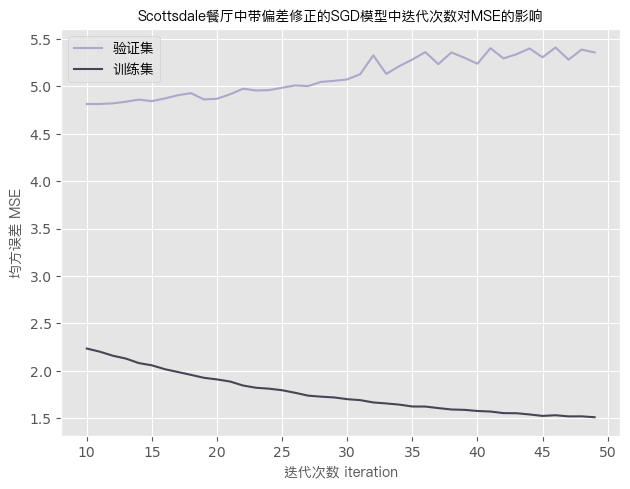

In [29]:
# 定义迭代次数的范围
iters = np.arange(10, 50, 1)
err_sgd_test_sct = []  # 存储验证集的误差
err_sgd_train_sct = []  # 存储训练集的误差

# 遍历不同的迭代次数
for i in iters:
    print('当前迭代次数 = ', i)

    # 使用带偏差校正的SGD训练模型
    preds_sgd = sgd_with_bias_correction(
        np.array(train_matrix.todense()), num_features=10, iterations=i)

    # 计算验证集和训练集的均方误差
    err_test = calculate_mse(preds_sgd[0], np.array(
        val_matrix.todense()))
    err_train = calculate_mse(preds_sgd[0], np.array(
        train_matrix.todense()))

    # 将结果添加到列表中
    err_sgd_test_sct.append(err_test)
    err_sgd_train_sct.append(err_train)

# 绘制迭代次数与MSE的关系图
plt.plot(iters, err_sgd_test_sct, label='验证集', color=plt_color[0])
plt.plot(iters, err_sgd_train_sct, label='训练集', color=plt_color[1])


plt.xlabel('迭代次数 iteration', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)

plt.legend(prop=PingFang)
plt.tight_layout()
plt.savefig('../images/Scottsdale/12_带偏差修正的SGD_MSE与迭代次数的关系.png', dpi=600)
plt.title('Scottsdale餐厅中带偏差修正的SGD模型中迭代次数对MSE的影响', fontproperties=PingFang)
plt.show()

可以设置我们的最佳迭代次数 = 30

当前特征数量 k= 2
当前特征数量 k= 3
当前特征数量 k= 4
当前特征数量 k= 5
当前特征数量 k= 7
当前特征数量 k= 8
当前特征数量 k= 9
当前特征数量 k= 11
当前特征数量 k= 12
当前特征数量 k= 13
当前特征数量 k= 15


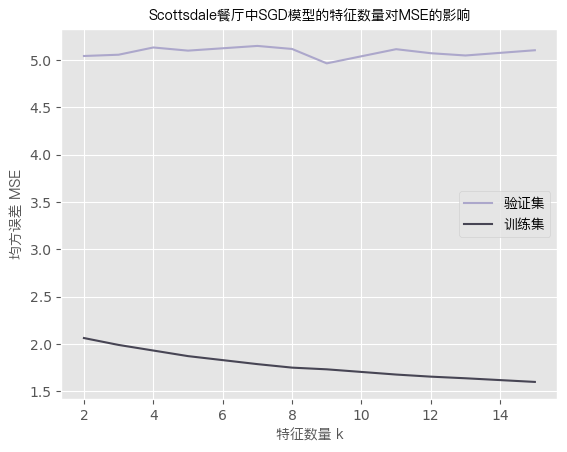

In [30]:
# 定义特征数量的范围
k = np.linspace(2, 15, 11, dtype=int)
err_sgd_val_sct = []  # 存储验证集的误差
err_sgd_train_sct = []  # 存储训练集的误差

# 遍历不同的特征数量
for i in k:
    print('当前特征数量 k=', i)

    # 使用带偏差校正的SGD进行模型训练
    preds_sgd = sgd_with_bias_correction(
        np.array(train_matrix.todense()), num_features=i, iterations=30)

    # 计算验证集和训练集的均方误差
    err_val = calculate_mse(preds_sgd[0], np.array(
        val_matrix.todense()))
    err_train = calculate_mse(preds_sgd[0], np.array(
        train_matrix.todense()))

    # 将结果添加到列表中
    err_sgd_val_sct.append(err_val)
    err_sgd_train_sct.append(err_train)

# 绘制特征数量与MSE的关系图
plt.plot(k, err_sgd_val_sct, label='验证集', color=plt_color[0])
plt.plot(k, err_sgd_train_sct, label='训练集', color=plt_color[1])


plt.xlabel('特征数量 k', fontproperties=PingFang)
plt.ylabel('均方误差 MSE', fontproperties=PingFang)

plt.legend(prop=PingFang)
plt.savefig('../images/Scottsdale/14_带偏差修正的SGD_特征数量与MSE关系.png', dpi=600)
plt.title('Scottsdale餐厅中SGD模型的特征数量对MSE的影响', fontproperties=PingFang)
plt.show()

可以设置我们的最佳特征数量 k 值 = 2

In [48]:
# 使用带偏己校正的SGD算法训练模型，并获取预测结果、误差数组、用户向量和资源向量
# 设置特征数量为2，迭代次数为23
predictions_sgd, error_array_sgd, user_vec_sgd, res_vec_sgd = sgd_with_bias_correction(
    np.array(train_matrix.todense()), num_features=2, iterations=23)

In [49]:
# 再次使用SGD算法进行训练，此次仅获取预测结果
preds_sgd_sct = sgd_with_bias_correction(
    np.array(train_matrix.todense()), num_features=2, iterations=30)

# 计算预测结果的均方误差MSE并打印
Best_Val_MSE_sgd_sct = calculate_mse(
    preds_sgd_sct[0], np.array(val_matrix.todense()))
print('Scottsdale餐厅SGD模型的最佳验证均方误差为：', Best_Val_MSE_sgd_sct)

Scottsdale餐厅SGD模型的最佳验证均方误差为： 5.066301508788498


In [33]:
# 使用预测结果对训练集、验证集和测试集的非零索引位置进行评分预测
train_prediction_sgd = preds_sgd_sct[0][train_nonzero_indices]
val_prediction_sgd = preds_sgd_sct[0][val_nonzero_indices]
test_prediction_sgd = preds_sgd_sct[0][test_nonzero_indices]

## 2.6 随机森林Random Forest
将矩阵补全问题转换为回归问题

随机森林回归器尝试学习用户潜在向量和餐厅潜在向量之间的非线性依赖关系。目标变量是用户i对餐厅j的评分。本质上它归结为一个回归问题。

将矩阵补全问题转换为回归问题的核心思想是利用用户和物品（餐厅）的特征向量来预测评分。矩阵补全问题的目标是填补评分矩阵中的缺失值，即预测用户尚未评分的物品（餐厅）评分。通过将问题转换为回归问题，我们可以利用特征向量（隐因子）来建立模型，从而实现评分预测。以下是详细解释：

In [34]:
# 拼接用户和物品特征向量，用于训练、验证和测试
train_sct = concatenate_user_item_vectors(user_vec_sgd, res_vec_sgd, train_matrix)
val_sct = concatenate_user_item_vectors(user_vec_sgd, res_vec_sgd, val_matrix)
test_sct = concatenate_user_item_vectors(user_vec_sgd, res_vec_sgd, test_matrix)

# 将拼接后的向量转换为numpy数组
train_mat_sct = np.array(train_sct)
val_mat_sct = np.array(val_sct)
test_mat_sct = np.array(test_sct)

In [35]:
x_train, y_train = train_mat_sct[:, :-1], np.ravel(train_mat_sct[:, -1])
x_val, y_val = val_mat_sct[:, :-1], np.ravel(val_mat_sct[:, -1])

In [36]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=5)

In [37]:
# 使用随机森林回归模型进行训练和预测
rf_sct = RandomForestRegressor(max_depth=5)
rf.fit(train_mat_sct[:, :4], train_mat_sct[:, 4])
# 在验证集上进行预测
preds_rf_sct = rf.predict(val_mat_sct[:, :4]).reshape(-1, 1)

MSE_rf_sct = calculate_mse(preds_rf_sct, val_mat_sct[:, 4])
print('斯科茨代尔餐厅随机森林分类器的均方误差 MSE =', MSE_rf_sct)

斯科茨代尔餐厅随机森林分类器的均方误差 MSE = 5.200148046015383


In [38]:
train_prediction_rf = rf.predict(train_mat_sct[:, :4])
val_prediction_rf = rf.predict(val_mat_sct[:, :4])
test_prediction_rf = rf.predict(test_mat_sct[:, :4])

# 3 评估
## 所有预测模型的集合（SVD，余弦模型，ALS，SGD，RF）

In [39]:
# 构建包含训练集预测结果的DataFrame
ensemble_training_sct_df = build_ensemble_dataframe(
    svd_predictions=train_predictions_svd,   # SVD模型的训练集预测结果
    cosine_predictions=train_prediction_cos,  # 余弦相似性模型的训练集预测结果
    als_predictions=train_prediction_als,    # ALS模型的训练集预测结果
    sgd_predictions=train_prediction_sgd,    # SGD模型的训练集预测结果
    rf_predictions=train_prediction_rf       # 随机森林模型的训练集预测结果
)

# 构建包含验证集预测结果的DataFrame
ensemble_validation_sct_df = build_ensemble_dataframe(
    svd_predictions=val_predictions_svd,     # SVD模型的验证集预测结果
    cosine_predictions=val_prediction_cos,   # 余弦相似性模型的验证集预测结果
    als_predictions=val_prediction_als,      # ALS模型的验证集预测结果
    sgd_predictions=val_prediction_sgd,      # SGD模型的验证集预测结果
    rf_predictions=val_prediction_rf         # 随机森林模型的验证集预测结果
)

# 构建包含测试集预测结果的DataFrame
ensemble_testing_sct_df = build_ensemble_dataframe(
    svd_predictions=test_predictions_svd,    # SVD模型的测试集预测结果
    cosine_predictions=test_prediction_cos,  # 余弦相似性模型的测试集预测结果
    als_predictions=test_prediction_als,     # ALS模型的测试集预测结果
    sgd_predictions=test_prediction_sgd,     # SGD模型的测试集预测结果
    rf_predictions=test_prediction_rf        # 随机森林模型的测试集预测结果
)

In [40]:
y_train_sct = np.ravel(
    np.array(train_matrix[train_nonzero_indices]))
y_val_sct = np.ravel(
    np.array(val_matrix[val_nonzero_indices]))
y_test_sct = np.ravel(
    np.array(test_matrix[test_nonzero_indices]))

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
lr_sct = LinearRegression(fit_intercept=True)
lr_sct.fit(ensemble_training_sct_df.iloc[:, -3:], y_train_sct)
ensemble_val_pred_sct = lr_sct.predict(ensemble_validation_sct_df.iloc[:, -3:])
MSE_ensemble_sct = calculate_mse(ensemble_val_pred_sct, y_val_sct)
print('斯科茨代尔餐厅模型集的均方误差 =', MSE_ensemble_sct)

斯科茨代尔餐厅模型集的均方误差 = 5.1747134145911975


高惩罚的岭回归

In [43]:
from sklearn.linear_model import Ridge
lrr_phx = Ridge(alpha=10000)

In [44]:
lrr_sct = Ridge(alpha=10000)
lrr_sct.fit(ensemble_training_sct_df.iloc[:, -3:], y_train_sct)
ensemble_val_pred_sct = lrr_sct.predict(
    ensemble_validation_sct_df.iloc[:, -3:])
MSE_ensemble_sct = calculate_mse(ensemble_val_pred_sct, y_val_sct)
print('斯科茨代尔餐厅模型集成的均方误差 =', MSE_ensemble_sct)

斯科茨代尔餐厅模型集成的均方误差 = 5.062250847909761


在测试数据上测试最佳模型并检查测试准确性**最佳模型是集成模型。**

In [45]:
ensemble_test_pred_sct = lrr_sct.predict(ensemble_testing_sct_df.iloc[:, -3:])
MSE_test_sct = calculate_mse(ensemble_test_pred_sct, y_test_sct)
print('斯科茨代尔餐厅模型集成的均方误差=', MSE_test_sct)

斯科茨代尔餐厅模型集成的均方误差= 5.61303961592906
